# MIIII

In [41]:
import jax.numpy as jnp
from jax import random
import jax
import numpy as np
from functools import partial
from sklearn.metrics import confusion_matrix, f1_score
from matplotlib import pyplot as plt
import seaborn as sns
import miiiii

In [12]:
seed = 0
cfg, (rng, key) = miiiii.get_conf(), random.split(random.PRNGKey(seed))
ns = partial(miiiii.base_ns, miiiii.digit_fn)
train_data, valid_data = miiiii.prime_fn(cfg.n, cfg.base, ns, rng)
params = miiiii.init_fn(key, cfg, *train_data)

# train
apply_fn = miiiii.make_apply_fn(miiiii.vaswani_fn)
train_fn, state = miiiii.init_train(apply_fn, params, cfg, train_data, valid_data)
(params, opt_state, ema_grads), metrics = train_fn(cfg.epochs, rng, state)

In [16]:
rng, key = random.split(rng)
(x_train, y_train), (x_valid, y_valid) = train_data, valid_data
train_pred = miiiii.predict_fn(apply_fn, params, x_train)
valid_pred = miiiii.predict_fn(apply_fn, params, x_valid)

In [17]:
(train_pred == y_train).mean(), (valid_pred == y_valid).mean()

(Array(0.8148804, dtype=float32), Array(0.8157959, dtype=float32))

In [62]:
noise = random.uniform(rng, (31, 31))
res = (valid_pred == y_valid)[:, 1:].mean(axis=0)[:, None]

tmp = jnp.concatenate([res, noise], axis=-1)
tmp = jnp.cumsum(tmp, axis=-1)
# row normalize
tmp = tmp / tmp.max(axis=-1, keepdims=True)

<Axes: >

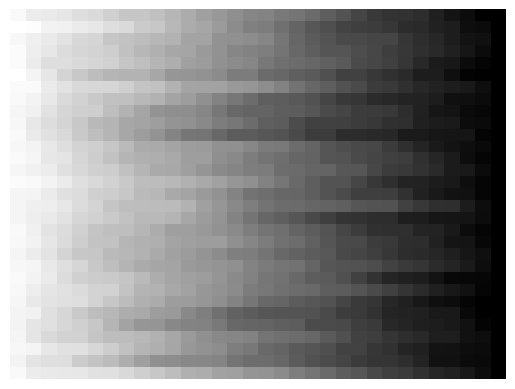

In [63]:
sns.heatmap(
    1 - np.array(tmp), cbar=False, cmap="gray", xticklabels=False, yticklabels=False
)

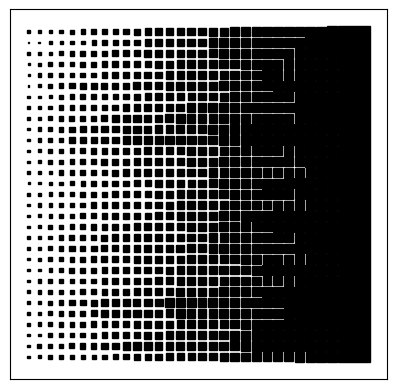

In [68]:
def hinton_ish(matrix, ax=None):
    ax = ax if ax is not None else plt.gca()
    max_weight = 2 ** np.ceil(np.log2(np.abs(matrix).max()))

    ax.patch.set_facecolor("white")
    ax.set_aspect("equal", "box")
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = "black"
        size = np.sqrt(abs(w) / max_weight)
        rect = plt.Rectangle(
            [x - size / 2, y - size / 2], size, size, facecolor=color, edgecolor=color
        )
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()


hinton_ish(np.array(tmp).T)
plt.show()

In [67]:
tmp

Array([[0.0452912 , 0.09649343, 0.1008401 , 0.11666974, 0.14883012,
        0.16309875, 0.2020918 , 0.23951939, 0.24184842, 0.2626375 ,
        0.30081627, 0.34008247, 0.38761377, 0.41680747, 0.4521693 ,
        0.48659244, 0.49802348, 0.53688335, 0.55009365, 0.58848083,
        0.6385534 , 0.6817124 , 0.73233205, 0.7807308 , 0.8039021 ,
        0.80852413, 0.8251145 , 0.8754664 , 0.9219245 , 0.9520125 ,
        0.99717903, 1.        ],
       [0.02039245, 0.03019316, 0.07396158, 0.07410821, 0.09717096,
        0.11431636, 0.14883117, 0.1647131 , 0.22126172, 0.23603731,
        0.29294273, 0.34161827, 0.36120492, 0.40483704, 0.4610742 ,
        0.5086524 , 0.51970917, 0.5689735 , 0.6136151 , 0.664952  ,
        0.6969111 , 0.7426608 , 0.7585693 , 0.7698887 , 0.7868949 ,
        0.8308095 , 0.8372559 , 0.8709916 , 0.8864633 , 0.94389206,
        0.95484215, 1.        ],
       [0.05255966, 0.08468065, 0.102552  , 0.13249418, 0.17204875,
        0.18422592, 0.24133518, 0.25647667, 0.2744